<a href="https://colab.research.google.com/github/fcoliveira-utfpr/nasapower_validation/blob/main/validation_eto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import libraries**
---

In [27]:
import numpy as np
import pandas as pd
import datetime
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline
%config inlineBackend.figure_formats = ['svg']
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

#**Data on meteorological elements and their deviations**
---

In [ ]:
# Data source URL
url_1 = "https://raw.githubusercontent.com/fcoliveira-utfpr/nasapower_validation/refs/heads/main/elements_and_std.csv"

# Read CSV file
dados = pd.read_csv(url_1)

# Preserve categorical columns
categorical_cols = ['Cidade', 'Base de dados']
dados_cat = dados[categorical_cols].copy()

# Process numerical columns
dados_num = (
    dados
    .drop(columns=categorical_cols)
    .replace(',', '.', regex=True)          # Replace comma with dot as decimal separator
    .apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coercing errors to NaN
)

# Rebuild final DataFrame
dados = pd.concat([dados_num, dados_cat], axis=1)

# Reverse row order and reset index
dados = dados.iloc[::-1].reset_index(drop=True)

dados

,UR (%),Vel (m/s),Rs (Mj/dia),TMax (ºC),Tmin (ºC),Qo (Mj/dia),dp-UR,dp-Vel,dp-Rs,dp-TMax,dp-Tmin,dp-Qo,Cidade,Base de dados
0,77.3,0.7,18.0,28.1,17.5,33.2,11.5,0.2,7.1,4.8,4.8,7.4,Sete Quedas,NASA/POWER
1,66.8,2.0,16.8,28.2,17.5,33.1,14.7,1.2,7.3,6.1,4.9,7.4,Sete Quedas,INMET
2,76.3,0.2,17.7,27.4,16.7,33.0,11.7,0.0,7.4,5.0,4.8,7.9,Planalto,NASA/POWER
3,64.6,2.4,17.7,27.9,17.2,32.9,16.5,1.2,8.1,5.1,4.5,7.8,Planalto,INMET
4,79.8,0.3,17.7,25.2,15.3,32.7,10.4,0.1,6.6,4.0,4.3,7.6,Nova Tebas,NASA/POWER
5,67.2,1.8,17.5,26.9,16.2,32.8,13.1,1.3,7.8,4.3,4.3,7.5,Nova Tebas,INMET
6,74.5,2.1,18.2,28.3,17.0,33.3,11.7,0.7,6.5,4.2,4.2,7.5,Maringá,NASA/POWER
7,63.6,2.1,18.7,28.6,18.3,33.3,14.4,0.7,7.0,4.2,3.6,7.3,Maringá,INMET
8,76.6,1.0,17.8,27.7,16.8,33.0,11.3,0.3,7.3,4.7,4.7,7.7,Marechal Cândido Rondon,NASA/POWER
9,67.9,3.1,17.5,28.5,17.1,33.0,12.2,1.4,7.4,4.9,4.6,7.6,Marechal Cândido Rondon,INMET


##Figure 2

/tmp/ipython-input-1244715386.py:105: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


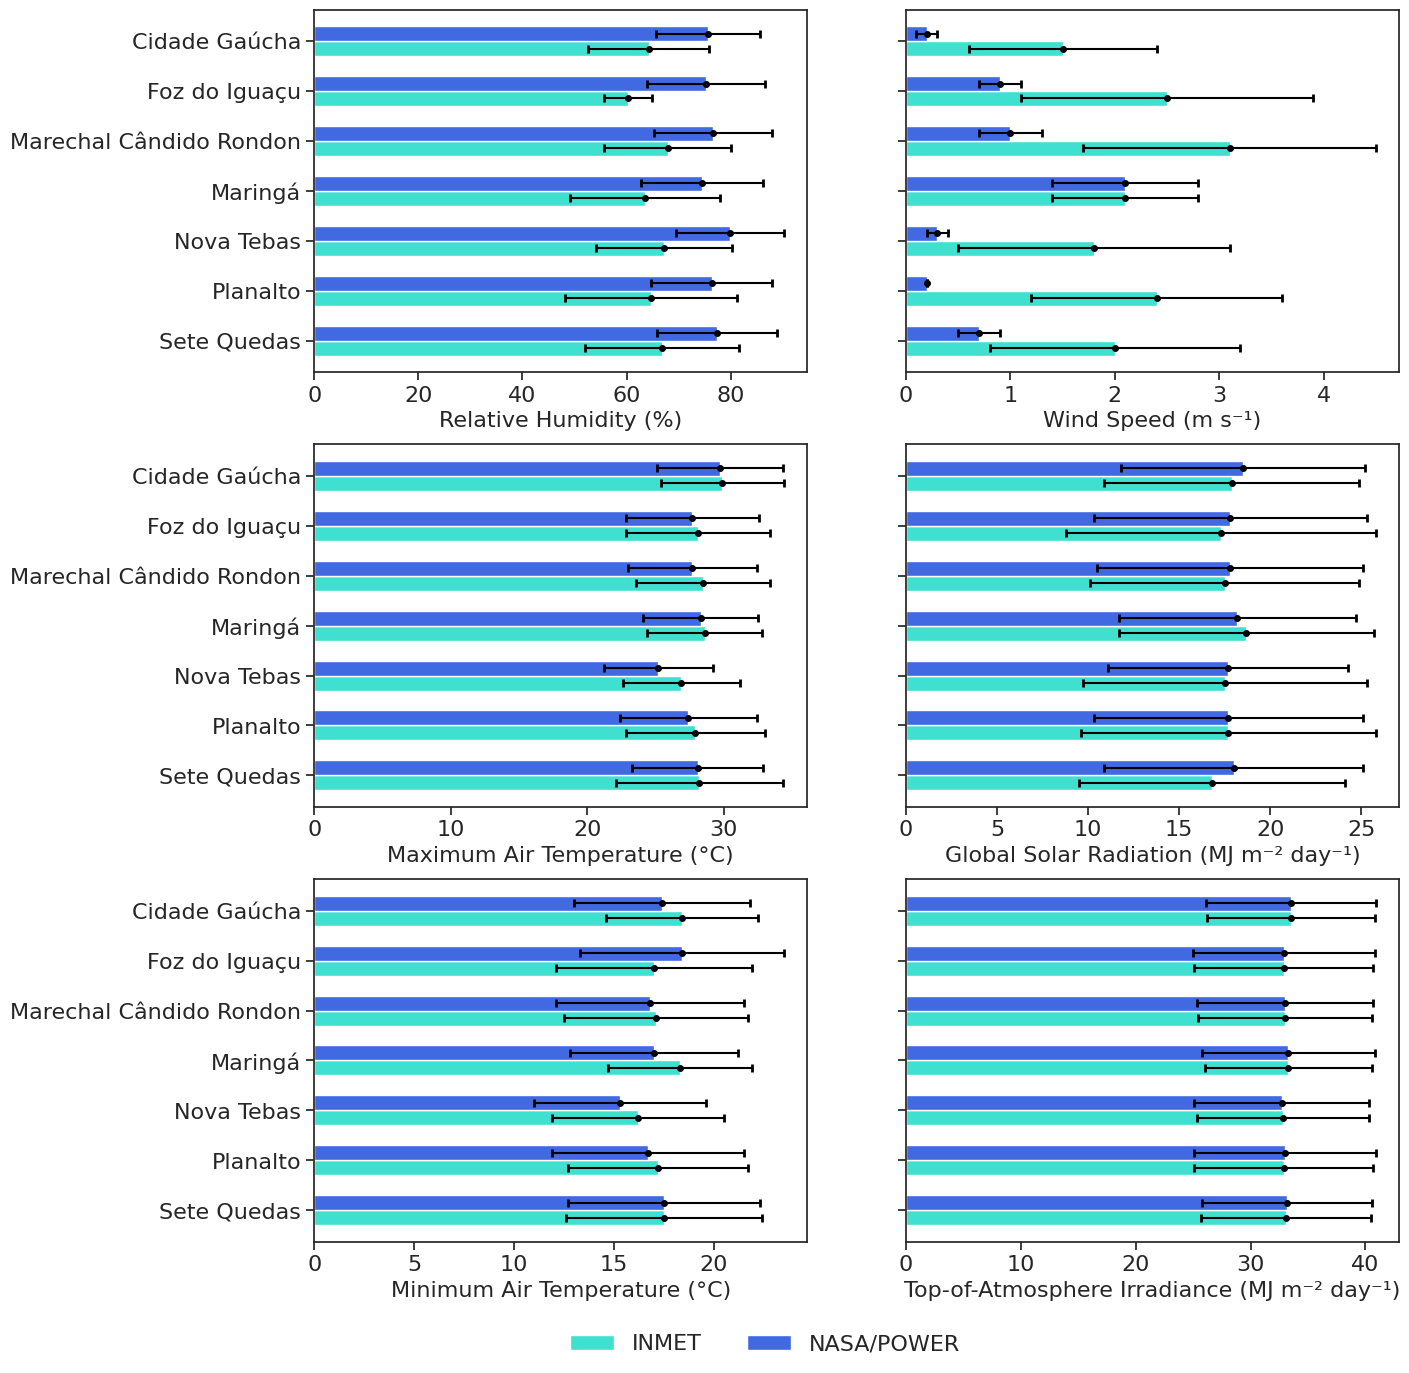

In [ ]:
# -------------------------------------------------------------------
# Data filtering by data source
# -------------------------------------------------------------------
inmet = dados[dados['Base de dados'] == 'INMET'].reset_index(drop=True)
npower = dados[dados['Base de dados'] == 'NASA/POWER'].reset_index(drop=True)

cities = npower['Cidade'].tolist()

# -------------------------------------------------------------------
# Plot configuration
# -------------------------------------------------------------------
sns.set()
sns.set_style('ticks')

fig, axs = plt.subplots(
    nrows=3, ncols=2,
    sharey=True,
    figsize=(14, 16)
)

bar_width = 0.3

# -------------------------------------------------------------------
# Helper function to center y-ticks between paired bars
# -------------------------------------------------------------------
def center_ticks(pos, width):
    return pos + width / 2

# -------------------------------------------------------------------
# Generic function to create horizontal bar plots with error bars
# -------------------------------------------------------------------
def plot_variable(ax, var, std, xlabel):
    y_inmet = np.arange(len(inmet[var]))
    y_np = y_inmet + bar_width

    # Horizontal bars
    ax.barh(y_inmet, inmet[var], bar_width, label='INMET', color='turquoise')
    ax.barh(y_np, npower[var], bar_width, label='NASA/POWER', color='royalblue')

    # Error bars
    ax.errorbar(
        inmet[var], y_inmet,
        xerr=inmet[std],
        fmt='o', markerfacecolor='navy', markeredgecolor='black', markeredgewidth=2, markersize=3, ecolor='black', capsize=3
    )
    ax.errorbar(
        npower[var], y_np,
        xerr=npower[std],
        fmt='o', markerfacecolor='navy', markeredgecolor='black', markeredgewidth=2, markersize=3, ecolor='black', capsize=3
    )

    ax.set_xlabel(xlabel, fontsize=16)
    ax.tick_params(axis='both', labelsize=16)

    return y_inmet

# -------------------------------------------------------------------
# Plot each variable
# -------------------------------------------------------------------
y0 = plot_variable(
    axs[0, 0], 'UR (%)', 'dp-UR',
    'Relative Humidity (%)'
)

plot_variable(
    axs[0, 1], 'Vel (m/s)', 'dp-Vel',
    'Wind Speed (m s⁻¹)'
)

plot_variable(
    axs[1, 1], 'Rs (Mj/dia)', 'dp-Rs',
    'Global Solar Radiation (MJ m⁻² day⁻¹)'
)

plot_variable(
    axs[1, 0], 'TMax (ºC)', 'dp-TMax',
    'Maximum Air Temperature (°C)'
)

plot_variable(
    axs[2, 0], 'Tmin (ºC)', 'dp-Tmin',
    'Minimum Air Temperature (°C)'
)

plot_variable(
    axs[2, 1], 'Qo (Mj/dia)', 'dp-Qo',
    'Top-of-Atmosphere Irradiance (MJ m⁻² day⁻¹)'
)

# -------------------------------------------------------------------
# Y-axis labels (cities)
# -------------------------------------------------------------------
plt.yticks(center_ticks(y0, bar_width), cities, fontsize=16)

# -------------------------------------------------------------------
# Legend
# -------------------------------------------------------------------
axs[0, 0].legend(
    fontsize=16,
    frameon=False,
    bbox_to_anchor=(1.35, -2.6),
    ncol=2
)

plt.tight_layout()
"""
Figure 2: Means and standard deviations of the values of relative humidity (RH),
wind speed (U2), global solar radiation (Rs), maximum temperature (Tmax),
minimum temperature (Tmin), and at the top-of-atmosphere irradiance (Qo) from INMET and NASA/POWER
"""

#**Meterics for season**
---

In [ ]:
# -------------------------------------------------------------------
# Data source URL
# -------------------------------------------------------------------
url_2 = "https://raw.githubusercontent.com/fcoliveira-utfpr/nasapower_validation/refs/heads/main/metricas_season.csv"

# Read CSV file
dados = pd.read_csv(url_2)

# Preserve categorical columns
categorical_cols = ['Cidade', 'Parametro', 'Estacao']
dados_cat = dados[categorical_cols].copy()

# Process numerical columns
dados_num = (
    dados
    .drop(columns=categorical_cols)
    .replace(',', '.', regex=True)          # Convert decimal separator
    .apply(pd.to_numeric, errors='coerce')  # Convert to numeric values
)

# Rebuild final DataFrame
dados = pd.concat([dados_num, dados_cat], axis=1)

dados


,Temp. Max. (C),Temp. Min. (C),Vel. Vento (m/s),Radiacao (MJ/mÂ²),UR Med (%),Qo,Cidade,Parametro,Estacao
0,0.92,0.95,-0.16,0.97,0.55,1.0,PNL,r,inverno
1,0.74,0.79,0.02,0.93,0.60,1.0,PNL,r,primavera
2,0.65,0.64,-0.03,0.86,0.47,1.0,PNL,r,verao
3,0.89,0.95,-0.10,0.96,0.34,1.0,PNL,r,outono
4,0.88,0.90,-0.08,0.97,0.67,1.0,NT,r,inverno
...,...,...,...,...,...,...,...,...,...
107,1.00,0.99,0.41,0.99,0.80,1.0,7Q,d,outono
108,0.99,0.91,0.57,1.00,0.66,1.0,CG,d,inverno
109,0.99,0.99,0.56,1.00,0.98,1.0,CG,d,primavera
110,1.00,0.99,0.61,0.99,0.75,1.0,CG,d,verao


##Figure 3

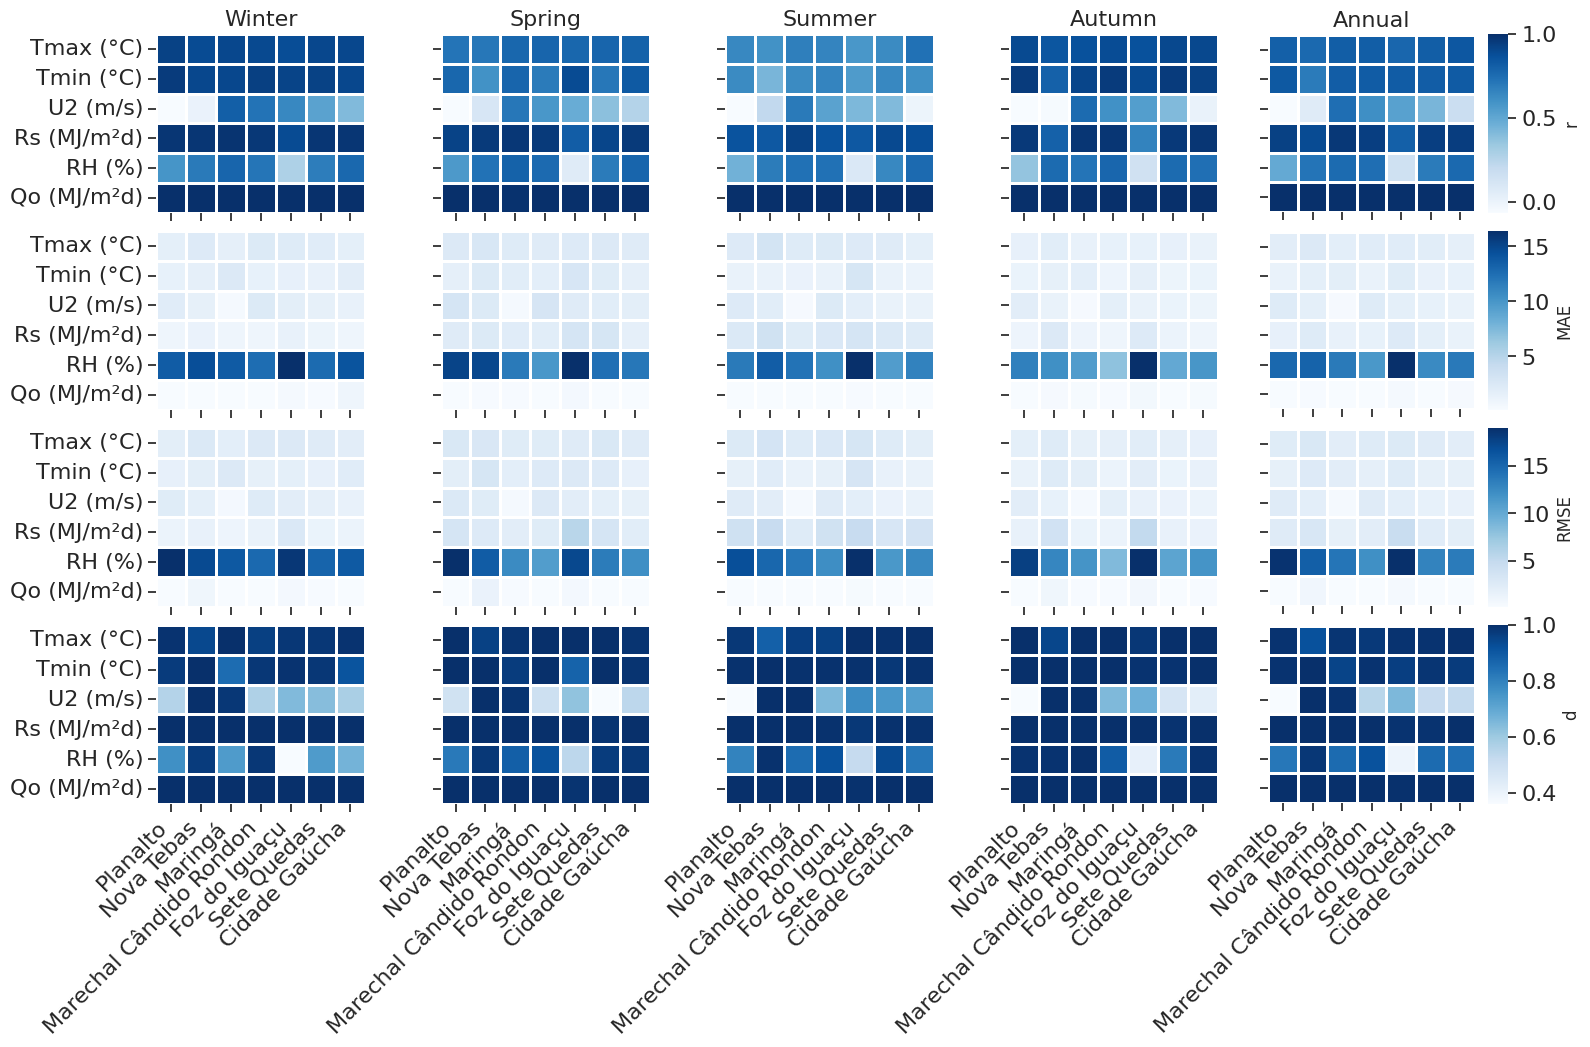

In [ ]:
sns.set_style('ticks')

# -------------------------------------------------------------------
# Definitions
# -------------------------------------------------------------------
metrics = ['r', 'MAE', 'RMSE', 'd']
seasons = ['inverno', 'primavera', 'verao', 'outono']

variables = [
    'Temp. Max. (C)',
    'Temp. Min. (C)',
    'Vel. Vento (m/s)',
    'Radiacao (MJ/mÂ²)',
    'UR Med (%)',
    'Qo'
]

row_labels = ['Tmax (°C)', 'Tmin (°C)', 'U2 (m/s)', 'Rs (MJ/m²d)', 'RH (%)', 'Qo (MJ/m²d)']
cities = ['Planalto','Nova Tebas','Maringá','Marechal Cândido Rondon',
          'Foz do Iguaçu','Sete Quedas','Cidade Gaúcha']

cmap = sns.color_palette("Blues", as_cmap=True)

# -------------------------------------------------------------------
# Helper function: build matrix for one metric and one season
# -------------------------------------------------------------------
def build_matrix(df, metric, season):
    subset = df[(df['Parametro'] == metric) & (df['Estacao'] == season)]
    return np.array([subset[var].values for var in variables])

# -------------------------------------------------------------------
# Build all matrices and DataFrames
# -------------------------------------------------------------------
dataframes = {}

for metric in metrics:
    seasonal_dfs = []

    for season in seasons:
        matrix = build_matrix(dados, metric, season)

        df_season = pd.DataFrame(
            matrix,
            index=row_labels,
            columns=cities
        )

        dataframes[(metric, season)] = df_season
        seasonal_dfs.append(df_season)

    # Annual mean
    dataframes[(metric, 'annual')] = sum(seasonal_dfs) / 4

# -------------------------------------------------------------------
# Plot configuration
# -------------------------------------------------------------------
fig, axs = plt.subplots(
    nrows=4, ncols=5,
    sharex=True, sharey=True,
    figsize=(18, 10)
)

plt.rcParams.update({'ytick.labelsize': 16})

titles = ['Winter', 'Spring', 'Summer', 'Autumn', 'Annual']

# -------------------------------------------------------------------
# Plot heatmaps
# -------------------------------------------------------------------
for i, metric in enumerate(metrics):
    for j, season in enumerate(seasons + ['annual']):

        show_cbar = (j == 4)

        sns.heatmap(
            dataframes[(metric, season)],
            cmap=cmap,
            square=True,
            linewidth=1,
            cbar=show_cbar,
            cbar_kws={
                'shrink': 1,
                'aspect': 9,
                'label': metric
            } if show_cbar else None,
            ax=axs[i, j]
        )

        if i == 0:
            axs[i, j].set_title(titles[j], fontsize=16)

# -------------------------------------------------------------------
# Axis labels formatting
# -------------------------------------------------------------------
for ax in axs[-1, :]:
    ax.set_xticklabels(cities, rotation=45, ha='right', fontsize=16)

for ax in axs[:, 0]:
    ax.tick_params(axis='both', labelsize=16)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
"""
Figure 3: Performance of the values of relative humidity (RH),
wind speed (U2), global solar radiation (Rs), maximum temperature (Tmax),
minimum temperature (Tmin),
and top-of-atmosphere irradiance (Qo) from the NASA/POWER reanalysis database
in relation to the INMET surface station data, considering Pearson's correlation (r),
mean absolute error (MAE), root mean square error (RMSE), and Wilmott's concordance index (d)
"""


#**Performance ETo values determined from NASA/POWER data**
---


In [7]:
# -------------------------------------------------------------------
# Data source URL
# -------------------------------------------------------------------
url_3 = "https://raw.githubusercontent.com/fcoliveira-utfpr/nasapower_validation/refs/heads/main/eto_values.csv"

# Read CSV file
df = pd.read_csv(url_3)
df

,Cidade,level_1,Eto - PM (mm/d),Eto - PM (mm/d)- NP,ETo - JH (mm/d),ETo - PT (mm/d)
0,Planalto,0,4.5,3.8,3.5,4.7
1,Planalto,1,6.2,4.7,4.3,5.9
2,Planalto,2,5.7,4.8,4.4,6.0
3,Planalto,3,6.7,5.8,5.2,7.2
4,Planalto,4,6.9,6.4,6.0,8.0
...,...,...,...,...,...,...
23932,Cidade Gaúcha,3257,6.6,6.5,6.5,8.2
23933,Cidade Gaúcha,3258,4.6,5.5,5.5,6.8
23934,Cidade Gaúcha,3259,4.1,3.8,3.6,4.7
23935,Cidade Gaúcha,3260,7.2,6.5,6.5,8.1


##Table 3

In [25]:
# ------------------------------------------------------------------
# Statistical performance metrics
# ------------------------------------------------------------------

def rmse(y_obs, y_sim):
    """Root Mean Square Error (RMSE)."""
    return np.sqrt(mean_squared_error(y_obs, y_sim))

def mae(y_obs, y_sim):
    """Mean Absolute Error (MAE)."""
    return mean_absolute_error(y_obs, y_sim)

def r_pearson(y_obs, y_sim):
    """Pearson correlation coefficient (r)."""
    return pearsonr(y_obs, y_sim)[0]

def nse(y_obs, y_sim):
    """Nash–Sutcliffe Efficiency (NSE)."""
    return 1 - np.sum((y_obs - y_sim)**2) / np.sum((y_obs - np.mean(y_obs))**2)


# ------------------------------------------------------------------
# Column definitions
# Observed values: FAO-56 Penman–Monteith ETo
# Simulated values: NASA/POWER-based methods
# ------------------------------------------------------------------

obs_col = 'Eto - PM (mm/d)'

sim_cols = {
    'FAO56-NP': 'Eto - PM (mm/d)- NP',
    'JH': 'ETo - JH (mm/d)',
    'PT': 'ETo - PT (mm/d)'
}


# ------------------------------------------------------------------
# Compute performance metrics by city and method
# ------------------------------------------------------------------

results = []

for cidade, df_cid in df.groupby('Cidade'):

    # Observed ETo (reference)
    y_obs = df_cid[obs_col].values

    for metodo, sim_col in sim_cols.items():

        # Simulated ETo
        y_sim = df_cid[sim_col].values

        # Remove NaN and infinite values (pairwise)
        mask = np.isfinite(y_obs) & np.isfinite(y_sim)
        y_o = y_obs[mask]
        y_s = y_sim[mask]

        # Skip cases with insufficient data
        if len(y_o) < 2:
            continue

        # Store metrics
        results.append({
            'Cidade': cidade,
            'Metodo': metodo,
            'RMSE (mm/d)': rmse(y_o, y_s),
            'MAE (mm/d)': mae(y_o, y_s),
            'r (Pearson)': r_pearson(y_o, y_s),
            'NSE': nse(y_o, y_s),
        })


# ------------------------------------------------------------------
# Final DataFrame with performance metrics
# ------------------------------------------------------------------

df_metricas = pd.DataFrame(results)


""""
Table 3: Performance of reference evapotranspiration (ETo) values
determined from NASA/POWER reanalysis data compared to surface station
data from INMET, considering Pearson's correlation coefficient (r),
Nash-Sutcliffe efficiency coefficient (NSE), mean absolute error (MAE),
and root mean square error (RMSE).
"""
df_metricas

,Cidade,Metodo,RMSE (mm/d),MAE (mm/d),r (Pearson),NSE
0,Cidade Gaúcha,FAO56-NP,0.697460,0.534703,0.928576,0.797916
1,Cidade Gaúcha,JH,1.101054,0.903158,0.895743,0.496369
2,Cidade Gaúcha,PT,1.089548,0.867474,0.925255,0.506840
3,Foz do Iguaçu,FAO56-NP,0.969508,0.739503,0.863177,0.669342
4,Foz do Iguaçu,JH,1.539171,1.323097,0.836499,0.166607
5,Foz do Iguaçu,PT,1.278474,0.953616,0.854945,0.425011
6,Marechal Cândido Rondon,FAO56-NP,0.904675,0.753700,0.905175,0.608916
7,Marechal Cândido Rondon,JH,1.732095,1.507539,0.853282,-0.433603
8,Marechal Cândido Rondon,PT,1.170562,0.949860,0.886281,0.345252
9,Maringá,FAO56-NP,0.433568,0.327426,0.956860,0.907030


##Figure 4

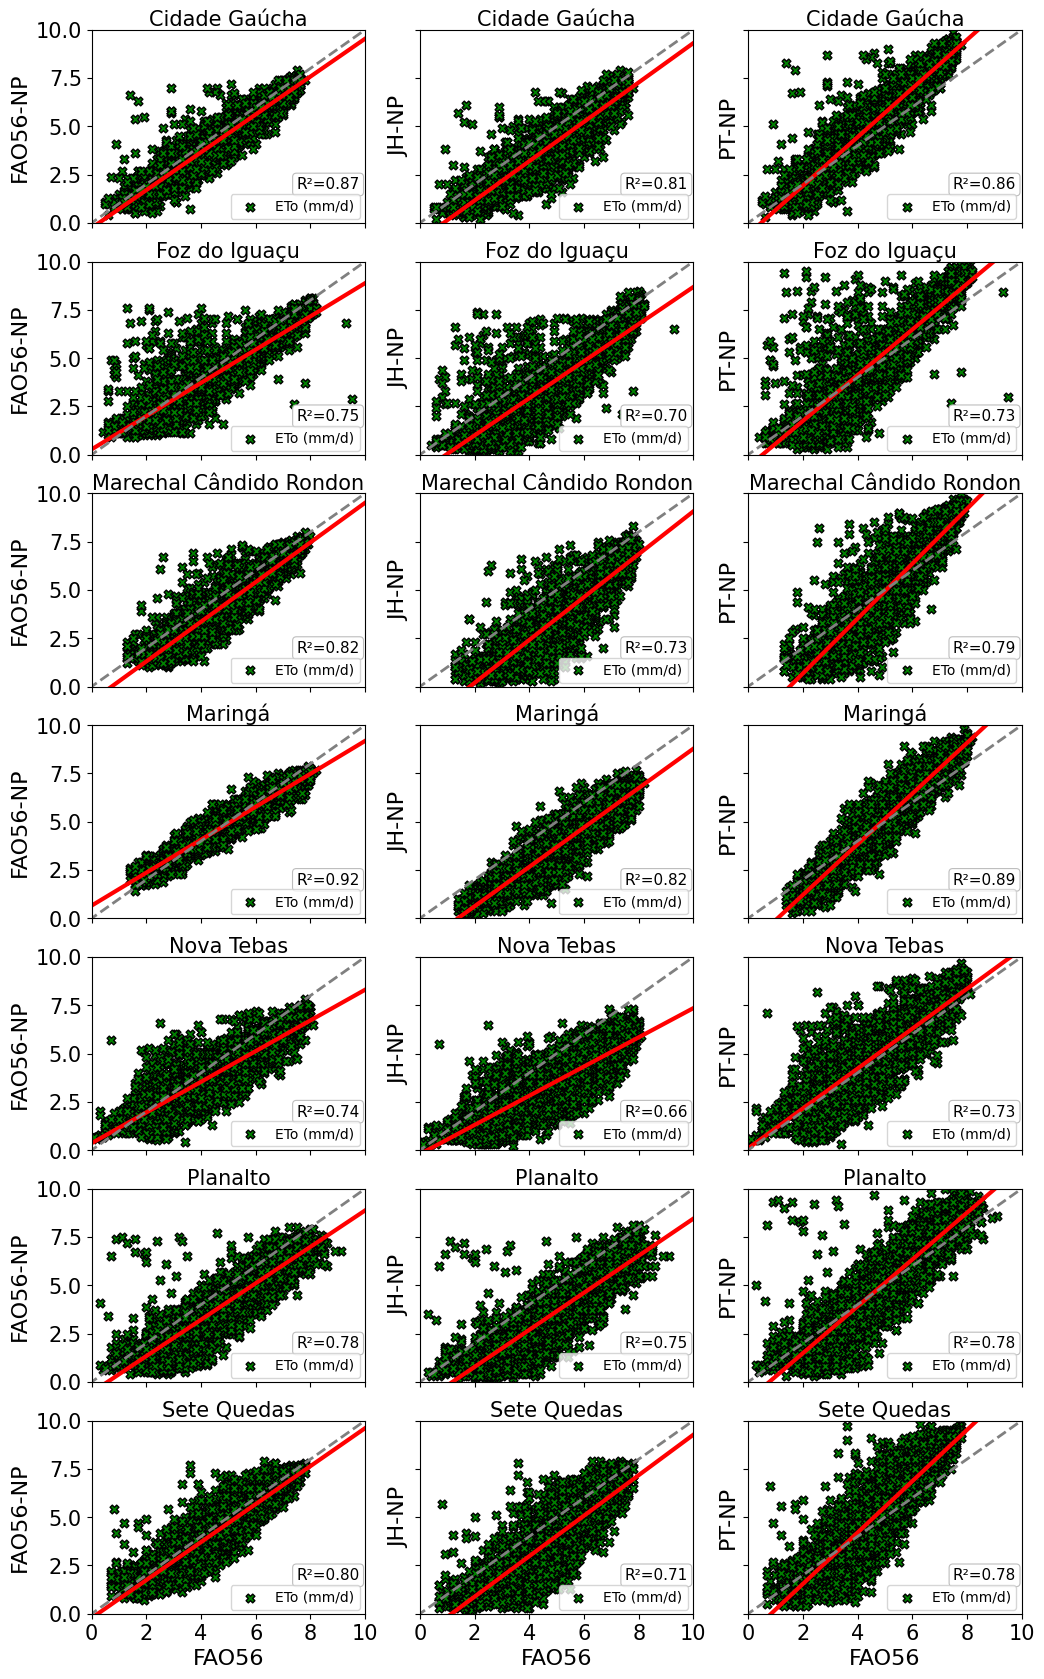

In [14]:
# ---------------------------------------------------------------------
# List of cities to be plotted (one row per city)
# ---------------------------------------------------------------------
cidades = [
    'Cidade Gaúcha',
    'Foz do Iguaçu',
    'Marechal Cândido Rondon',
    'Maringá',
    'Nova Tebas',
    'Planalto',
    'Sete Quedas'
]

# Number of cities (used to define subplot grid)
n_cidades = len(cidades)

# Create figure with shared axes (same visual scale for all panels)
figs, axs = plt.subplots(
    nrows=n_cidades,
    ncols=3,
    sharex=True,
    sharey=True,
    figsize=(12, 18)
)

# ---------------------------------------------------------------------
# Outlier filtering based only on the reference variable (PM, x-axis)
# ---------------------------------------------------------------------
def _iqr_bounds(v, k=1.5):
    """
    Compute lower and upper bounds using the Interquartile Range (IQR).
    """
    q1, q3 = np.nanpercentile(v, [25, 75])
    iqr = q3 - q1
    return q1 - k * iqr, q3 + k * iqr


def filter_by_x_outliers(x, y, method="iqr", k=1.5, p_low=1, p_high=99):
    """
    Filter paired (x, y) data by removing outliers based only on x values.
    """
    d = (
        pd.DataFrame({"x": x, "y": y})
        .replace([np.inf, -np.inf], np.nan)
        .dropna()
    )

    if d.empty:
        return d

    if method == "iqr":
        lo, hi = _iqr_bounds(d["x"].values, k=k)
    elif method == "percentile":
        lo, hi = np.nanpercentile(d["x"].values, [p_low, p_high])
    else:
        lo, hi = -np.inf, np.inf

    mask = (d["x"] >= lo) & (d["x"] <= hi)
    return d.loc[mask]


def fit_mb(x_raw, y_raw, **fkwargs):
    """
    Fit a linear regression (y = m*x + b) after filtering x-based outliers.
    Returns slope, intercept, R², and filtered data.
    """
    d = filter_by_x_outliers(x_raw, y_raw, **fkwargs)

    if d.empty:
        return np.nan, np.nan, np.nan, d

    X = sm.add_constant(d["x"].values)
    res = sm.OLS(d["y"].values, X).fit()

    slope = res.params[1]
    intercept = res.params[0]
    r2 = res.rsquared

    return slope, intercept, r2, d


# ---------------------------------------------------------------------
# Outlier filter parameters (applied only to PM values)
# ---------------------------------------------------------------------
OUTLIER_METHOD_X = "iqr"     # Options: "iqr" or "percentile"
IQR_K_X = 1.5                # Tukey criterion (higher = more tolerant)
P_LOW_X, P_HIGH_X = 1, 99    # Used only if percentile method is selected

# ---------------------------------------------------------------------
# Anchors for legend and R² annotation (axis coordinates: 0–1)
# ---------------------------------------------------------------------
LEG_X, LEG_Y = 0.98, 0.02    # Legend position (bottom-right)
R2_X, R2_Y = 0.98, 0.16      # R² position (above legend)

# ---------------------------------------------------------------------
# 1:1 reference line (perfect agreement)
# ---------------------------------------------------------------------
x_11 = [-1, 0, 2, 4, 6, 8, 10, 12]
y_11 = [-1, 0, 2, 4, 6, 8, 10, 12]

# Base x-range used to draw regression lines
xline = np.array([0, 10])

# ---------------------------------------------------------------------
# Function to draw one row (three panels) for a given city
# ---------------------------------------------------------------------
def desenha_linha(axrow, x_PM, y_PMNP, y_JH, y_PT, titulo):

    # ---- Panel 1: FAO56 vs FAO56-NP ----
    m1, b1, r21, d1 = fit_mb(
        x_PM, y_PMNP,
        method=OUTLIER_METHOD_X,
        k=IQR_K_X,
        p_low=P_LOW_X,
        p_high=P_HIGH_X
    )

    axrow[0].scatter(
        d1["x"], d1["y"],
        label='ETo (mm/d)',
        marker='X',
        color='green',
        s=40,
        edgecolor='black'
    )

    if not np.isnan(m1):
        axrow[0].plot(xline, m1 * xline + b1, color='red', linewidth=3)

    axrow[0].axis([0, 10, 0, 10])
    axrow[0].set_ylabel('FAO56-NP', fontsize=16)
    axrow[0].legend(
        frameon=True,
        loc='lower right',
        bbox_to_anchor=(LEG_X, LEG_Y),
        borderaxespad=0.
    )
    axrow[0].plot(x_11, y_11, color='gray', linewidth=2, linestyle='--')

    if not np.isnan(r21):
        axrow[0].text(
            R2_X, R2_Y, f"R²={r21:.2f}",
            transform=axrow[0].transAxes,
            ha='right',
            va='bottom',
            fontsize=11,
            bbox=dict(
                boxstyle="round,pad=0.25",
                fc="white",
                ec="#bdbdbd",
                lw=0.8
            ),
            zorder=5
        )

    # ---- Panel 2: FAO56 vs JH-NP ----
    m2, b2, r22, d2 = fit_mb(
        x_PM, y_JH,
        method=OUTLIER_METHOD_X,
        k=IQR_K_X,
        p_low=P_LOW_X,
        p_high=P_HIGH_X
    )

    axrow[1].scatter(d2["x"], d2["y"], label='ETo (mm/d)',
                     marker='X', color='green', s=40, edgecolor='black')

    if not np.isnan(m2):
        axrow[1].plot(xline, m2 * xline + b2, color='red', linewidth=3)

    axrow[1].axis([0, 10, 0, 10])
    axrow[1].set_ylabel('JH-NP', fontsize=16)
    axrow[1].legend(frameon=True, loc='lower right',
                     bbox_to_anchor=(LEG_X, LEG_Y), borderaxespad=0.)
    axrow[1].plot(x_11, y_11, color='gray', linewidth=2, linestyle='--')

    if not np.isnan(r22):
        axrow[1].text(R2_X, R2_Y, f"R²={r22:.2f}",
                      transform=axrow[1].transAxes,
                      ha='right', va='bottom', fontsize=11,
                      bbox=dict(boxstyle="round,pad=0.25",
                                fc="white", ec="#bdbdbd", lw=0.8),
                      zorder=5)

    # ---- Panel 3: FAO56 vs PT-NP ----
    m3, b3, r23, d3 = fit_mb(
        x_PM, y_PT,
        method=OUTLIER_METHOD_X,
        k=IQR_K_X,
        p_low=P_LOW_X,
        p_high=P_HIGH_X
    )

    axrow[2].scatter(d3["x"], d3["y"], label='ETo (mm/d)',
                     marker='X', color='green', s=40, edgecolor='black')

    if not np.isnan(m3):
        axrow[2].plot(xline, m3 * xline + b3, color='red', linewidth=3)

    axrow[2].axis([0, 10, 0, 10])
    axrow[2].set_ylabel('PT-NP', fontsize=16)
    axrow[2].legend(frameon=True, loc='lower right',
                     bbox_to_anchor=(LEG_X, LEG_Y), borderaxespad=0.)
    axrow[2].plot(x_11, y_11, color='gray', linewidth=2, linestyle='--')

    if not np.isnan(r23):
        axrow[2].text(R2_X, R2_Y, f"R²={r23:.2f}",
                      transform=axrow[2].transAxes,
                      ha='right', va='bottom', fontsize=11,
                      bbox=dict(boxstyle="round,pad=0.25",
                                fc="white", ec="#bdbdbd", lw=0.8),
                      zorder=5)

    # Set the city title for all three panels
    for ax in axrow:
        ax.set_title(titulo, size=15, pad=3)


# ---------------------------------------------------------------------
# Loop through cities and draw each row of panels
# ---------------------------------------------------------------------
for i, cidade in enumerate(cidades):

    df_cid = df[df['Cidade'] == cidade]

    x_PM = df_cid['Eto - PM (mm/d)'].values
    y_PMNP = df_cid['Eto - PM (mm/d)- NP'].values
    y_JH = df_cid['ETo - JH (mm/d)'].values
    y_PT = df_cid['ETo - PT (mm/d)'].values

    desenha_linha(axs[i], x_PM, y_PMNP, y_JH, y_PT, cidade)


# ---------------------------------------------------------------------
# Axis labels and tick formatting
# ---------------------------------------------------------------------
# X-axis labels only on the last row
for j in range(3):
    axs[-1, j].set_xlabel('FAO56', fontsize=16)

# Y-axis tick formatting
for i in range(n_cidades):
    axs[i, 0].tick_params(axis='y', labelsize=15)

# X-axis tick formatting
for j in range(3):
    axs[-1, j].tick_params(axis='x', labelsize=15)

# Adjust subplot spacing
plt.subplots_adjust(
    left=0.125,
    bottom=0.1,
    right=0.9,
    top=0.98,
    wspace=0.2,
    hspace=0.2
)
""""
Figure 4: Scatter plots of reference evapotranspiration (ETo) values
estimated using NASA/POWER reanalysis data (FAO56-NP) compared to
surface station data from INMET (PM) for the seven evaluated
municipalities
"""

# **Performance ETo values using U2**
---

In [38]:
# -------------------------------------------------------------------
# Data source URL
# -------------------------------------------------------------------
url_4 = "https://raw.githubusercontent.com/fcoliveira-utfpr/nasapower_validation/refs/heads/main/df_general.csv"
# Read CSV file
df = pd.read_csv(url_4)
df

,YEAR,DOY,ALLSKY_SFC_SW_DWN,T2M_MIN,T2M_MAX,PRECTOTCORR,RH2M,WS2M,T Med (ºC),UR Med (%),...,Irradiância solar extraterrestre (Qo=RA) (MJ/m²d),BOC,Qg CS,BOL,Rn (MJ/m²d),Eto - PM (mm/d),latitude,altitude,Municipio,ETo_superficie
0,2011.0,1.0,19.96,20.13,31.29,0.23,77.62,0.09,25.71,77.62,...,42.82,15.37,32.44,0.00,15.37,4.78,-23.38,381.0,Cidade Gaúcha,5.51
1,2011.0,2.0,26.37,19.36,31.38,8.60,79.38,0.08,25.37,79.38,...,42.42,20.30,32.14,0.00,20.30,6.27,-23.38,381.0,Cidade Gaúcha,5.28
2,2011.0,3.0,21.09,20.63,32.00,10.53,75.06,0.20,26.32,75.06,...,42.44,16.24,32.15,0.00,16.24,5.12,-23.38,381.0,Cidade Gaúcha,5.09
3,2011.0,4.0,21.34,21.24,29.92,1.65,75.06,0.24,25.58,75.06,...,42.46,16.43,32.17,0.00,16.43,5.15,-23.38,381.0,Cidade Gaúcha,4.54
4,2011.0,5.0,23.26,22.11,30.84,12.18,78.12,0.21,26.48,78.12,...,42.48,17.91,32.18,0.00,17.91,5.64,-23.38,381.0,Cidade Gaúcha,6.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18260,2020.0,362.0,27.58,19.10,35.44,0.28,57.88,0.20,27.27,57.88,...,43.15,21.24,32.70,3.89,25.12,7.81,-25.72,398.0,Planalto,1.38
18261,2020.0,363.0,25.32,21.89,34.12,3.11,64.81,0.20,28.01,64.81,...,43.16,19.50,32.71,3.42,22.91,7.16,-25.72,398.0,Planalto,1.88
18262,2020.0,364.0,21.00,22.04,33.70,8.55,69.06,0.17,27.87,69.06,...,43.17,16.17,32.72,3.26,19.43,6.13,-25.72,398.0,Planalto,0.01
18263,2020.0,365.0,27.38,21.67,33.37,3.86,72.94,0.18,27.52,72.94,...,43.19,21.08,32.74,3.24,24.32,7.65,-25.72,398.0,Planalto,1.80


In [39]:
# -------------------------------------------------------------------
# Copy original dataframe to avoid modifying the source
# -------------------------------------------------------------------
df_np = df.copy()

# -------------------------------------------------------------------
# Atmospheric pressure calculation (kPa)
# FAO-56 standard equation based on altitude (m)
# -------------------------------------------------------------------
df_np['Patm'] = 101.3 * ((293 - 0.0065 * df_np['altitude']) / 293) ** 5.26

# -------------------------------------------------------------------
# Psychrometric constant (kPa °C⁻¹)
# -------------------------------------------------------------------
df_np['gama'] = 0.665e-3 * df_np['Patm']

# -------------------------------------------------------------------
# Rename columns to standardized names
# -------------------------------------------------------------------
df_np = df_np.rename(columns={
    's (kPa)': 's',
    'Rn (MJ/m²d)': 'Rn',
    'WS2M': 'U2',
    'es (kPA)': 'es',
    'ea (kPa)': 'ea',
    'T Med (ºC)': 'Tmed'
})

# -------------------------------------------------------------------
# Define wind speed scenarios (m s⁻¹)
# -------------------------------------------------------------------
df_np['U_0_5'] = 0.5
df_np['U_1']   = 1.0
df_np['U_1_5'] = 1.5
df_np['U_2']   = 2.0

# -------------------------------------------------------------------
# FAO Penman-Monteith reference evapotranspiration function
# -------------------------------------------------------------------
def eto_pm(s, Rn, gamma, u2, es, ea, tmean):
    """
    Compute reference evapotranspiration (ETo) using FAO-56
    Penman-Monteith equation.
    """
    num_rad = 0.408 * s * Rn
    num_aero = (gamma * 900 * u2 * (es - ea)) / (tmean + 273)
    den = s + gamma * (1 + 0.34 * u2)
    return (num_rad + num_aero) / den

# -------------------------------------------------------------------
# ETo calculations for different wind speed scenarios
# -------------------------------------------------------------------
df_np['ETo_PM_NP'] = eto_pm(df_np['s'], df_np['Rn'], df_np['gama'],
                            df_np['U2'], df_np['es'], df_np['ea'], df_np['Tmed'])

df_np['ETo_U05'] = eto_pm(df_np['s'], df_np['Rn'], df_np['gama'],
                          df_np['U_0_5'], df_np['es'], df_np['ea'], df_np['Tmed'])

df_np['ETo_U1'] = eto_pm(df_np['s'], df_np['Rn'], df_np['gama'],
                         df_np['U_1'], df_np['es'], df_np['ea'], df_np['Tmed'])

df_np['ETo_U1_5'] = eto_pm(df_np['s'], df_np['Rn'], df_np['gama'],
                           df_np['U_1_5'], df_np['es'], df_np['ea'], df_np['Tmed'])

df_np['ETo_U2'] = eto_pm(df_np['s'], df_np['Rn'], df_np['gama'],
                         df_np['U_2'], df_np['es'], df_np['ea'], df_np['Tmed'])

# -------------------------------------------------------------------
# Reference ETo calculated at surface (already available)
# -------------------------------------------------------------------
df_np['ETo_PM_sup'] = df_np['ETo_superficie']

# -------------------------------------------------------------------
# Final dataframe with selected ETo scenarios
# -------------------------------------------------------------------
df_ETo = df_np[
    ['ETo_PM_NP', 'ETo_U05', 'ETo_U1', 'ETo_U1_5', 'ETo_U2', 'ETo_PM_sup', 'Municipio']
]

df_ETo

,ETo_PM_NP,ETo_U05,ETo_U1,ETo_U1_5,ETo_U2,ETo_PM_sup,Municipio
0,4.755899,4.811767,4.875155,4.933873,4.988418,5.51,Cidade Gaúcha
1,6.183546,6.175244,6.166082,6.157617,6.149775,5.28,Cidade Gaúcha
2,5.052438,5.111250,5.203271,5.288511,5.367694,5.09,Cidade Gaúcha
3,5.051873,5.099468,5.185483,5.264939,5.338560,4.54,Cidade Gaúcha
4,5.547319,5.574312,5.618040,5.658546,5.696173,6.36,Cidade Gaúcha
...,...,...,...,...,...,...,...
18260,7.803094,7.871331,7.978110,8.077033,8.168934,1.38,Planalto
18261,7.087078,7.106794,7.137647,7.166229,7.192783,1.88,Planalto
18262,6.088093,6.123254,6.173265,6.219715,6.262973,0.01,Planalto
18263,7.591436,7.582395,7.569122,7.556795,7.545315,1.80,Planalto


##Figure 5

In [41]:
# -------------------------------------------------------------------
# Data source URL
# -------------------------------------------------------------------
url_5 = "https://raw.githubusercontent.com/fcoliveira-utfpr/nasapower_validation/refs/heads/main/metricas_eto_vs_u2.csv"
# Read CSV file
df = pd.read_csv(url_5)
cidades = df.Municipio
index = df['Indices estatísticos']
df = df.replace({',': '.'}, regex=True)
df = df.apply(lambda x: pd.to_numeric(x, errors = 'coerce'), axis=1)
df['Municipio'] = cidades
df['Indices estatísticos'] = index
df

,Indices estatísticos,ETo_PM_NP,ETo_U05,ETo_U1,"ETo_U1,5",ETo_U2,Municipio
0,EAM,0.53,0.47,0.41,0.40,0.45,Cidade Gaúcha
1,RMSE,0.70,0.64,0.58,0.59,0.65,Cidade Gaúcha
2,corr_p,0.93,0.93,0.93,0.93,0.93,Cidade Gaúcha
3,CE,0.80,0.83,0.86,0.86,0.82,Cidade Gaúcha
4,d,0.95,0.96,0.96,0.96,0.95,Cidade Gaúcha
5,r2,0.80,0.83,0.86,0.86,0.82,Cidade Gaúcha
6,EAM,0.74,0.85,0.72,0.63,0.59,Foz do Iguaçú
7,RMSE,0.97,1.08,0.96,0.90,0.88,Foz do Iguaçú
8,corr_p,0.86,0.86,0.86,0.86,0.85,Foz do Iguaçú
9,CE,0.67,0.59,0.67,0.72,0.73,Foz do Iguaçú


'"\nFigure 5: Performance of reference evapotranspiration (ETo) values \ndetermined using U2 values from the NASA/POWER reanalysis data \ncompared to constant U2 values, considering Pearson\'s correlation (r), \nmean absolute error (MAE), root mean square error (RMSE), \nand Nash-Sutcliffe efficiency coefficient (NSE)\n'

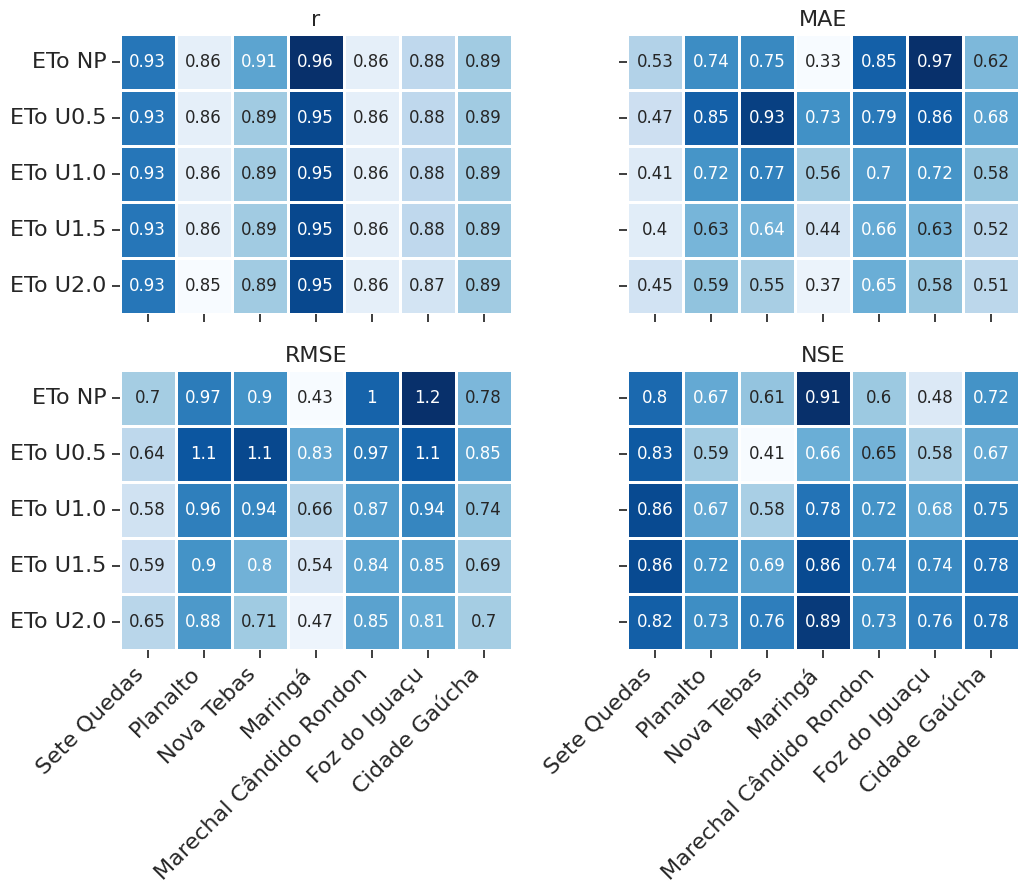

In [46]:
# List of municipalities to be used as columns in the heatmaps
city = [
    'Sete Quedas',
    'Planalto',
    'Nova Tebas',
    'Maringá',
    'Marechal Cândido Rondon',
    'Foz do Iguaçu',
    'Cidade Gaúcha'
]

# ------------------------------------------------------------------
# Filter the DataFrame by statistical index
# ------------------------------------------------------------------
df_r    = df.loc[df['Indices estatísticos'] == 'corr_p']
df_MAE  = df.loc[df['Indices estatísticos'] == 'EAM']
df_RMSE = df.loc[df['Indices estatísticos'] == 'RMSE']
df_CE   = df.loc[df['Indices estatísticos'] == 'CE']

# ------------------------------------------------------------------
# Build matrices for each statistical metric
# Rows = ETo methods | Columns = municipalities
# ------------------------------------------------------------------
matriz_r = np.array([
    df_r['ETo_PM_NP'],
    df_r['ETo_U05'],
    df_r['ETo_U1'],
    df_r['ETo_U1,5'],
    df_r['ETo_U2']
])

matriz_MAE = np.array([
    df_MAE['ETo_PM_NP'],
    df_MAE['ETo_U05'],
    df_MAE['ETo_U1'],
    df_MAE['ETo_U1,5'],
    df_MAE['ETo_U2']
])

matriz_RMSE = np.array([
    df_RMSE['ETo_PM_NP'],
    df_RMSE['ETo_U05'],
    df_RMSE['ETo_U1'],
    df_RMSE['ETo_U1,5'],
    df_RMSE['ETo_U2']
])

matriz_CE = np.array([
    df_CE['ETo_PM_NP'],
    df_CE['ETo_U05'],
    df_CE['ETo_U1'],
    df_CE['ETo_U1,5'],
    df_CE['ETo_U2']
])

# ------------------------------------------------------------------
# Convert matrices into DataFrames for plotting
# ------------------------------------------------------------------
eto_labels = ['ETo NP', 'ETo U0.5', 'ETo U1.0', 'ETo U1.5', 'ETo U2.0']

dados_grafico1 = pd.DataFrame(matriz_r,    index=eto_labels, columns=city)
dados_grafico2 = pd.DataFrame(matriz_MAE,  index=eto_labels, columns=city)
dados_grafico3 = pd.DataFrame(matriz_RMSE, index=eto_labels, columns=city)
dados_grafico4 = pd.DataFrame(matriz_CE,   index=eto_labels, columns=city)

# ------------------------------------------------------------------
# Seaborn style configuration
# ------------------------------------------------------------------
sns.set()
sns.set_style('ticks')

# Create a 2x2 subplot layout
figs, axs = plt.subplots(
    nrows=2,
    ncols=2,
    sharex=True,
    sharey=True,
    figsize=(12, 8)
)

# Define colormap
cor = sns.color_palette("Blues", as_cmap=True)

# X and Y axis labels
para_eixo_x_t1 = city
para_eixo_y = eto_labels

# ------------------------------------------------------------------
# First row: Pearson correlation (r) and MAE
# ------------------------------------------------------------------
grafico1 = sns.heatmap(
    dados_grafico1,
    cmap=cor,
    xticklabels=para_eixo_x_t1,
    yticklabels=para_eixo_y,
    square=True,
    cbar=False,
    annot=True,
    linewidth=1,
    ax=axs[0, 0]
)

grafico2 = sns.heatmap(
    dados_grafico2,
    cmap=cor,
    xticklabels=para_eixo_x_t1,
    square=True,
    cbar=False,
    annot=True,
    linewidth=1,
    ax=axs[0, 1]
)

# ------------------------------------------------------------------
# Second row: RMSE and Nash–Sutcliffe Efficiency (NSE)
# ------------------------------------------------------------------
grafico3 = sns.heatmap(
    dados_grafico3,
    cmap=cor,
    xticklabels=para_eixo_x_t1,
    square=True,
    cbar=False,
    annot=True,
    linewidth=1,
    ax=axs[1, 0]
)

grafico4 = sns.heatmap(
    dados_grafico4,
    cmap=cor,
    xticklabels=para_eixo_x_t1,
    square=True,
    cbar=False,
    annot=True,
    linewidth=1,
    ax=axs[1, 1]
)

# ------------------------------------------------------------------
# Axis formatting
# ------------------------------------------------------------------
axs[0, 0].tick_params(axis='both', which='major', labelsize=16, rotation=0)
axs[1, 0].tick_params(axis='both', which='major', labelsize=16, rotation=0)
axs[1, 1].tick_params(axis='both', which='major', labelsize=16, rotation=0)

axs[1, 0].set_xticklabels(para_eixo_x_t1, rotation=45, size=16, ha='right')
axs[1, 1].set_xticklabels(para_eixo_x_t1, rotation=45, size=16, ha='right')

# ------------------------------------------------------------------
# Titles for each subplot
# ------------------------------------------------------------------
axs[0, 0].set_title('r', size=16)
axs[0, 1].set_title('MAE', size=16)
axs[1, 0].set_title('RMSE', size=16)
axs[1, 1].set_title('NSE', size=16)


""""
Figure 5: Performance of reference evapotranspiration (ETo) values
determined using U2 values from the NASA/POWER reanalysis data
compared to constant U2 values, considering Pearson's correlation (r),
mean absolute error (MAE), root mean square error (RMSE),
and Nash-Sutcliffe efficiency coefficient (NSE)
"""


# **Performance ETo values using ETo_sur e ETO_NP and ETo_U2**
---

In [49]:
# -------------------------------------------------------------------
# Data source URL
# -------------------------------------------------------------------
url_5 = "https://raw.githubusercontent.com/fcoliveira-utfpr/nasapower_validation/refs/heads/main/dados_ET.csv"
# Read CSV file
df = pd.read_csv(url_5)
df = df.replace({',': '.'}, regex=True)
df = df.apply(lambda x: pd.to_numeric(x, errors = 'coerce'), axis=1)
df

,CGEto-PM,CGEto-NP,CGEto-NP-10,MCREto-PM,MCREto-NP,MCREto-NP-2,FOZEto-PM,FOZEto-NP,FOZEto-NP-2,7Eto-PM,...,7Eto-NP-2,PEto-PM,PEto-NP,PEto-NP-2,NTEto-PM,NTEto-NP,NTEto-NP-2,MEto-PM,MEto-NP,MEto-NP-2
0,5.51,4.66,4.83,4.29,3.19,3.80,3.18,2.95,3.5,3.62,...,4.60,4.52,3.79,4.50,4.63,4.48,4.90,6.22,6.20,6.20
1,5.28,4.76,4.97,6.65,6.57,6.80,6.40,6.57,6.8,7.19,...,7.00,6.17,4.74,5.30,2.91,3.34,3.90,6.60,5.90,5.90
2,5.09,4.20,4.45,5.15,5.35,5.70,6.73,5.85,6.1,6.02,...,6.40,5.70,4.84,5.40,6.06,5.39,5.70,4.52,5.93,6.10
3,4.54,3.52,3.81,6.25,6.34,6.60,7.24,6.72,6.9,6.64,...,7.00,6.70,5.75,6.20,6.49,5.53,5.90,5.55,5.46,5.70
4,6.36,4.58,4.80,7.55,6.88,7.10,7.95,7.16,7.3,7.01,...,6.60,6.94,6.42,6.70,6.72,6.17,6.50,5.83,5.11,5.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3586,4.76,4.41,4.71,5.12,4.52,4.89,4.90,4.49,4.9,6.13,...,7.30,4.98,4.12,4.85,4.73,4.10,4.65,5.08,4.99,4.95
3587,4.76,4.41,4.71,5.12,4.52,4.89,4.90,4.49,4.9,3.27,...,6.10,4.98,4.12,4.85,4.73,4.10,4.65,5.08,4.99,4.95
3588,4.76,4.41,4.71,5.12,4.52,4.89,4.90,4.49,4.9,2.85,...,3.40,4.98,4.12,4.85,4.73,4.10,4.65,5.08,4.99,4.95
3589,4.76,4.41,4.71,5.12,4.52,4.89,4.90,4.49,4.9,5.19,...,6.70,4.98,4.12,4.85,4.73,4.10,4.65,5.08,4.99,4.95


##Figure 6

/tmp/ipython-input-3056909474.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[i].boxplot(
/tmp/ipython-input-3056909474.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[i].boxplot(
/tmp/ipython-input-3056909474.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[i].boxplot(
/tmp/ipython-input-3056909474.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[i].boxplot(
/tmp/ipython-input-3056909474.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() h

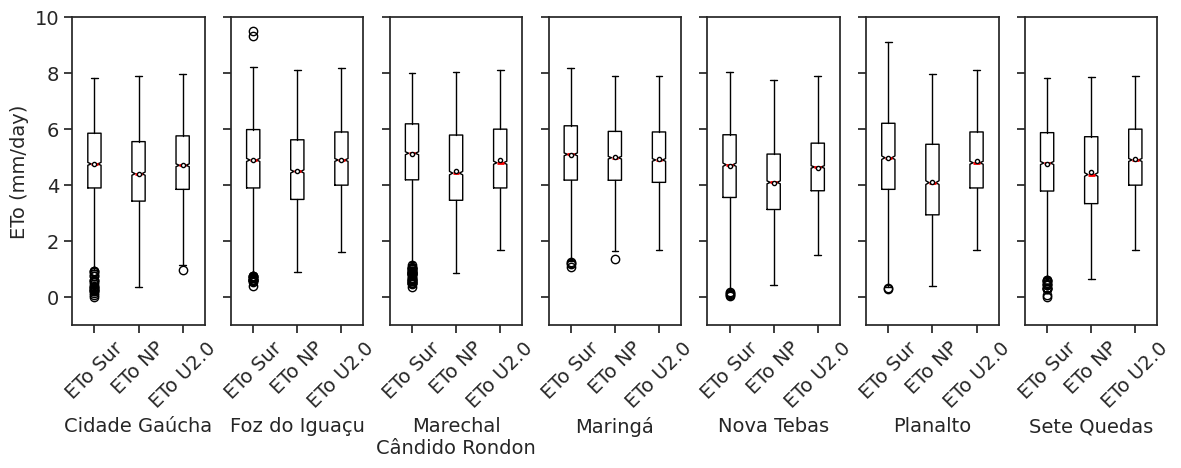

In [51]:
# List of municipalities to be used as labels in the plots
city = [
    'Sete Quedas',
    'Planalto',
    'Nova Tebas',
    'Maringá',
    'Marechal Cândido Rondon',
    'Foz do Iguaçu',
    'Cidade Gaúcha'
]

# ------------------------------------------------------------------
# Group ETo series for each municipality
# Each group contains:
# [Observed ETo (surface or PM), Non-standard PM, PM with fixed wind speed]
# ------------------------------------------------------------------
g_CG  = [df['CGEto-PM'].to_list(),
         df['CGEto-NP'].to_list(),
         df['CGEto-NP-10'].to_list()]

g_P   = [df['PEto-PM'], df['PEto-NP'], df['PEto-NP-2']]
g_FOZ = [df['FOZEto-PM'], df['FOZEto-NP'], df['FOZEto-NP-2']]
g_MCR = [df['MCREto-PM'], df['MCREto-NP'], df['MCREto-NP-2']]
g_M   = [df['MEto-PM'], df['MEto-NP'], df['MEto-NP-2']]
g_NT  = [df['NTEto-PM'], df['NTEto-NP'], df['NTEto-NP-2']]
g_7   = [df['7Eto-PM'],  df['7Eto-NP'],  df['7Eto-NP-2']]

# Set Seaborn style
sns.set()
sns.set_style('ticks')

# Combine all municipality datasets into a single list
dados = [g_CG, g_FOZ, g_MCR, g_M, g_NT, g_P, g_7]

# ------------------------------------------------------------------
# Create a figure with 7 subplots (one for each municipality)
# ------------------------------------------------------------------
figs, axs = plt.subplots(
    nrows=1,
    ncols=7,
    sharex=False,
    sharey=True,
    figsize=(14, 4)
)

# ------------------------------------------------------------------
# Loop over datasets and create a boxplot in each subplot
# ------------------------------------------------------------------
for i, data in enumerate(dados):

    axs[i].boxplot(
        data,
        notch=True,
        labels=['ETo Sur', 'ETo NP', 'ETo U2.0'],
        showmeans=True,
        meanprops={
            'marker': 'o',
            'markerfacecolor': 'white',
            'markersize': '3',
            'markeredgecolor': 'black'
        },
        medianprops={
            'linewidth': '2',
            'color': 'red'
        }
    )

    # Axis formatting
    axs[i].tick_params(axis='x', which='major', labelsize=14, rotation=45)
    axs[i].tick_params(axis='y', which='major', labelsize=14, rotation=0)
    axs[i].set_ylim([-1, 10])

    # ------------------------------------------------------------------
    # Add labels: Y-axis only on the first subplot
    # X-axis labels correspond to each municipality
    # ------------------------------------------------------------------
    if i == 0:
        axs[i].set_ylabel('ETo (mm/day)', fontsize=14)
        axs[i].set_xlabel('Cidade Gaúcha', fontsize=14)

    if i == 1:
        axs[i].set_xlabel('Foz do Iguaçu', fontsize=14)

    if i == 2:
        axs[i].set_xlabel('Marechal\nCândido Rondon', fontsize=14)

    if i == 3:
        axs[i].set_xlabel('Maringá', fontsize=14)

    if i == 4:
        axs[i].set_xlabel('Nova Tebas', fontsize=14)

    if i == 5:
        axs[i].set_xlabel('Planalto', fontsize=14)

    if i == 6:
        axs[i].set_xlabel('Sete Quedas', fontsize=14)
""""
Figure 6: Boxplot of reference evapotranspiration (ETo) values
determined using surface station data (ETo Sur), NASA/POWER reanalysis
data (ETo NP), and NASA/POWER data with constant U2 values set
at 2.0 m s-1,
for the seven evaluated cities
""""
